## Utilities

In [8]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
import cftime
from scipy.stats import linregress
from EWS_functions import *
from get_subpolar_gyre_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

### EWS plot functions

In [1]:
def get_EWS(time,data,trend,ws):
    linfits = []
    ps = []
    bound = ws // 2
    
    std = runstd(data - trend, ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], std[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(std[:-2], 1000, p0))
    
    ar1 = runac(data - trend, ws)[bound : -bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-3], ar1[:-3], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(ar1[:-2], 1000, p0))
    
    lam = run_fit_a_ar1(data-trend,ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], lam[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(lam[:-2], 1000, p0))
    
    return std, ar1, lam, linfits, ps

In [2]:
def plot_EWS(data, timess, ws=70, col='k',lbl='',alph=1,lw=1):
    bound = ws // 2
    popt, cov = curve_fit(funcfit3, timess, data, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
    trend = funcfit3(timess, *popt)
    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    ax1.plot(timess[bound : -bound],std,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(std[:-2],1000,linfits[1][0])
    ax1.plot(timess[bound : -bound][:-2],linfits[0][0] * timess[bound : -bound][:-2] + linfits[0][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax2.plot(timess[bound : -bound],ar1,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(ar1[:-2],1000,linfits[1][0])
    ax2.plot(timess[bound : -bound][:-2],linfits[1][0] * timess[bound : -bound][:-2] + linfits[1][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=alph,lw=lw)
    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope
#     ax3.plot(timess[bound : -bound][:-2], p0 * timess[bound : -bound][:-2]**2+p1 * timess[bound : -bound][:-2] + p2, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))
    ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

In [4]:
nparray = np.empty((8, 10, 1980))
nparray.fill(np.nan)
dims = ('models', 'ensemble_members', 'time')
models = ['CESM2','HadGEM3-GC31-LL',
 'CNRM-CM6-1',
 'GISS-E2-1-G',
 'MIROC6',
 'CanESM5',
 'BCC-CSM2-MR',
 'IPSL-CM6A-LR']
ensemble_members = ['r{}i1p1f1'.format(i) for i in range(1,11)]
time = np.arange(np.datetime64('1850-01'), np.datetime64('2015-01'))


# aer_amoc_index = xr.DataArray(
#     nparray,
#     dims = dims,
#     coords = dict(
#         models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#         time        = xr.DataArray(time, dims="time", coords=dict(time=("time", time))),
#         ensemble_members = xr.DataArray(ensemble_members, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensemble_members))),
#         )
#     )
ghg_amoc_index = xr.DataArray(
    nparray,
    dims = dims,
    coords = dict(
        models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
        time        = xr.DataArray(time, dims="time", coords=dict(time=("time", time))),
        ensemble_members = xr.DataArray(ensemble_members, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensemble_members))),
        )
    )
nat_amoc_index = xr.DataArray(
    nparray,
    dims = dims,
    coords = dict(
        models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
        time        = xr.DataArray(time, dims="time", coords=dict(time=("time", time))),
        ensemble_members = xr.DataArray(ensemble_members, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensemble_members))),
        )
    )
# aer_amoc_index.to_netcdf('hist_aer_amoc_index.nc')
# nat_amoc_index.to_netcdf('hist_nat_amoc_index.nc')
# ghg_amoc_index.to_netcdf('hist_ghg_amoc_index.nc')

In [5]:
# Region
latitude_maximum = 61
latitude_minimum = 46
longitude_maximum = 360-20
longitude_minimum = 360-55

set_boundaries(
    longitude_maximum = longitude_maximum,
    longitude_minimum = longitude_minimum,
    latitude_maximum = latitude_maximum,
    latitude_minimum = latitude_minimum
)

# these seem to be the three latitude/longitude keys
lat_keys = ['lat', 'latitude', 'nav_lat']
lon_keys = ['lon', 'longitude', 'nav_lon']

set_lon_lat_keys(
    longitudes=lon_keys,
    latitudes =lat_keys
)


get_values()

lon_min: 305
lon_max: 340
lat_min: 46
lat_max: 61
lon_keys: ['lon', 'longitude', 'nav_lon']
lat_keys: ['lat', 'latitude', 'nav_lat']


In [87]:
path_base = '/p/tmp/mayayami/SYNDA/data/CMIP6/DAMIP/'
institutes = os.listdir(path_base)

        
print('-------------\n aer')
aerpaths_all_models = dict()

for i in institutes:
    pi = path_base + i
    models = os.listdir(pi)
    for m in models:
        pim = pi + '/' + m + '/hist-aer/'
        try:
            emembers = os.listdir(pim)
            tmp = dict()
            for v in emembers:
                paths = [x[0] for x in os.walk(pim+v)]
                data_paths = []
                for path in paths:
                    if glob.glob("{}/tos_Omon_*.nc".format(path)):
                        data_paths.append(glob.glob("{}/tos_Omon_*.nc".format(path)))
                if (len(data_paths)) != 1:
                    print("Several paths provided for model '"+m+"' and ensemble member '"+v+"'!"+str(len(data_paths)))
                    data_paths = [p for p in data_paths if '_gn_' in p[0]]
                tmp[v] = data_paths
            aerpaths_all_models[m] = tmp
        except:
            print("No hist-aer for ", m)
        
print('-------------\n ghg')
ghgpaths_all_models = dict()

for i in institutes:
    pi = path_base + i
    models = os.listdir(pi)
    for m in models:
        pim = pi + '/' + m + '/hist-GHG/'
        try:
            emembers = os.listdir(pim)
            tmp = dict()
            for v in emembers:
                paths = [x[0] for x in os.walk(pim+v)]
                data_paths = []
                for path in paths:
                    if glob.glob("{}/tos_Omon_*.nc".format(path)):
                        data_paths.append(glob.glob("{}/tos_Omon_*.nc".format(path)))
                if (len(data_paths)) != 1:
                    print("Several paths provided for model '"+m+"' and ensemble member '"+v+"'!"+str(len(data_paths)))
                    data_paths = [p for p in data_paths if '_gn_' in p[0]]
                tmp[v] = data_paths
            ghgpaths_all_models[m] = tmp
        except:
            print('No hist-GHG for ', m)
        
print('-------------\n nat')
natpaths_all_models = dict()

for i in institutes:
    pi = path_base + i
    models = os.listdir(pi)
    for m in models:
        pim = pi + '/' + m + '/hist-nat/'
        try:
            emembers = os.listdir(pim)
            tmp = dict()
            for v in emembers:
                paths = [x[0] for x in os.walk(pim+v)]
                data_paths = []
                for path in paths:
                    if glob.glob("{}/tos_Omon_*.nc".format(path)):
                        data_paths.append(glob.glob("{}/tos_Omon_*.nc".format(path)))
                if (len(data_paths)) != 1:
                    print("Several paths provided for model '"+m+"' and ensemble member '"+v+"'!"+str(len(data_paths)))
                    data_paths = [p for p in data_paths if '_gn_' in p[0]]
                tmp[v] = data_paths
            natpaths_all_models[m] = tmp
        except:
            print('No hist-nat for ',m)

-------------
 aer
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r3i1p1f2'!2
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r1i1p1f2'!2
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r2i1p1f2'!2
-------------
 ghg
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r3i1p1f2'!2
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r1i1p1f2'!2
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r2i1p1f2'!2
-------------
 nat
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r3i1p1f2'!2
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r1i1p1f2'!2
Several paths provided for model 'CNRM-CM6-1' and ensemble member 'r2i1p1f2'!2
No hist-nat for  GISS-E2-1-G


## Do it for DAMIP

In [36]:
aer_amoc_index = xr.open_dataarray("hist_aer_amoc_index.nc")
# aer_amoc_index = time_to_year_month(aer_amoc_index)
# # Test with one ensemble member per model
# for model, emembers in aerpaths_all_models.items():
#     print('------------------------------------------')
#     print(model)
#     print_info = True
#     for emember in list(emembers.keys()):
#         emember_in_amoc_index = emember[:-1]+"1" 
# # 
#         spg = get_subpolar_gyre(
#             model   = model,
#             emember =  emember, 
#             print_info = print_info, 
#             paths_all_models = aerpaths_all_models)
#         # 
#         mask_time = (spg.time <= np.datetime64('2014-12-01'))
#         spg = spg.where(mask_time, drop=True)
# # 
#         if not spg is None:
#             print_info = False
#             aer_amoc_index.loc[dict(models=model, ensemble_members=emember_in_amoc_index)] = spg
# aer_amoc_index.to_netcdf('hist_aer_amoc_index.nc')

In [113]:
# # nat_amoc_index = xr.open_dataarray("hist_nat_amoc_index.nc")
# nat_amoc_index = time_to_year_month(nat_amoc_index)
# # Test with one ensemble member per model
# for model, emembers in natpaths_all_models.items():
#     print('------------------------------------------')
#     print(model)
#     print_info = True
#     for emember in list(emembers.keys()):
#         emember_in_amoc_index = emember[:-1]+"1" 

#         spg = get_subpolar_gyre(
#             model   = model,
#             emember =  emember, 
#             print_info = print_info, 
#             paths_all_models = natpaths_all_models)
        
#         mask_time = (spg.time <= np.datetime64('2014-12-01'))
#         spg = spg.where(mask_time, drop=True)
        
#         if not spg is None:
#             print_info = False
#             nat_amoc_index.loc[dict(models=model, ensemble_members=emember_in_amoc_index)] = spg
# nat_amoc_index.to_netcdf('hist_nat_amoc_index.nc')

In [115]:
# # ghg_amoc_index = xr.open_dataarray("hist_ghg_amoc_index.nc")
# ghg_amoc_index = time_to_year_month(ghg_amoc_index)

# for model, emembers in ghgpaths_all_models.items():
#     print('------------------------------------------')
#     print(model)
#     print_info = True
#     for emember in list(emembers.keys()):
#         emember_in_amoc_index = emember[:-1]+"1" 

#         spg = get_subpolar_gyre(
#             model   = model,
#             emember =  emember, 
#             print_info = print_info, 
#             paths_all_models = ghgpaths_all_models)
        
#         mask_time = (spg.time <= np.datetime64('2014-12-01'))
#         spg = spg.where(mask_time, drop=True)


#         if not spg is None:
#             print_info = False
#             ghg_amoc_index.loc[dict(models=model, ensemble_members=emember_in_amoc_index)] = spg
        
# ghg_amoc_index.to_netcdf('hist_ghg_amoc_index.nc')

## Add one specific model

In [101]:
model = 'CNRM-CM6-1'#'HadGEM3-GC31-LL'#'GISS-E2-1-G'#'CNRM-CM6-1'

In [95]:
# aer

aer_amoc_index = xr.open_dataarray("hist_aer_amoc_index.nc")
aer_amoc_index = time_to_year_month(aer_amoc_index)
# Test with one ensemble member per model
emembers = aerpaths_all_models[model]
print('------------------------------------------')
print(model)
print_info = True
for emember in list(emembers.keys()):
    emember_in_amoc_index = emember[:-1]+"1" 

    spg = get_subpolar_gyre(
        model   = model,
        emember =  emember, 
        print_info = print_info, 
        paths_all_models = aerpaths_all_models)

    mask_time = (spg.time <= np.datetime64('2014-12-01'))
    spg = spg.where(mask_time, drop=True)

    if not spg is None:
        print_info = False
        aer_amoc_index.loc[dict(models=model, ensemble_members=emember_in_amoc_index)] = spg
        
aer_amoc_index.to_netcdf('hist_aer_amoc_index.nc', mode = "a")


------------------------------------------
HadGEM3-GC31-LL
   + Longitude: longitude
   + Latitude:  latitude
   The mean is taken over the dimensions  ['j', 'i']
  Ensemble-members added:
    - r2i1p1f3
    - r5i1p1f3
    - r1i1p1f3
    - r4i1p1f3
    - r3i1p1f3


In [102]:
# nat

nat_amoc_index = xr.open_dataarray("hist_nat_amoc_index.nc")
nat_amoc_index = time_to_year_month(nat_amoc_index)

emembers = natpaths_all_models[model]#
print('------------------------------------------')
print(model)
print_info = True
for emember in list(emembers.keys()):
    emember_in_amoc_index = emember[:-1]+"1" 

    spg = get_subpolar_gyre(
        model   = model,
        emember =  emember, 
        print_info = print_info, 
        paths_all_models = natpaths_all_models)
    
    mask_time = (spg.time <= np.datetime64('2014-12-01'))
    spg = spg.where(mask_time, drop=True)
    
    if not spg is None:
        print_info = False
        nat_amoc_index.loc[dict(models=model, ensemble_members=emember_in_amoc_index)] = spg
nat_amoc_index.to_netcdf('hist_nat_amoc_index.nc', mode='a')

------------------------------------------
CNRM-CM6-1
   + Longitude: lon
   + Latitude:  lat
   The mean is taken over the dimensions  ['y', 'x']
  Ensemble-members added:
    - r3i1p1f2
    - r7i1p1f2
    - r4i1p1f2
    - r10i1p1f2
    - r8i1p1f2
    - r1i1p1f2
    - r5i1p1f2
    - r9i1p1f2
    - r2i1p1f2
    - r6i1p1f2


In [103]:
# ghg
 
ghg_amoc_index = xr.open_dataarray("hist_ghg_amoc_index.nc")
ghg_amoc_index = time_to_year_month(ghg_amoc_index)

emembers = ghgpaths_all_models[model]
print('------------------------------------------')
print(model)
print_info = True
for emember in list(emembers.keys()):
    emember_in_amoc_index = emember[:-1]+"1" 

    spg = get_subpolar_gyre(
        model   = model,
        emember =  emember, 
        print_info = print_info, 
        paths_all_models = ghgpaths_all_models)
    
    mask_time = (spg.time <= np.datetime64('2014-12-01'))
    spg = spg.where(mask_time, drop=True)


    if not spg is None:
        print_info = False
        ghg_amoc_index.loc[dict(models=model, ensemble_members=emember_in_amoc_index)] = spg
        
ghg_amoc_index.to_netcdf('hist_ghg_amoc_index.nc', mode ="a")

------------------------------------------
CNRM-CM6-1
   + Longitude: lon
   + Latitude:  lat
   The mean is taken over the dimensions  ['y', 'x']
  Ensemble-members added:
    - r3i1p1f2
    - r7i1p1f2
    - r4i1p1f2
    - r10i1p1f2
    - r8i1p1f2
    - r1i1p1f2
    - r5i1p1f2
    - r9i1p1f2
    - r2i1p1f2
    - r6i1p1f2


# Full file

In [5]:
with open('matthew/JSON_data/Figure_AR6_DAMIP_AMOC_26N_1000m.json', 'r') as handle:
    json_load = json.load(handle)

amoc_damip6_ts = np.ma.asarray(json_load["amoc_damip6_ts"])  # Note the use of numpy masked arrays (np.ma)
damip6_models = json_load["damip6_models"]
year = np.asarray(json_load["year"])

In [6]:
experiments_damip6 = ['historical', 'hist-aer', 'hist-GHG', 'hist-nat', 'hist-stratO3']

In [9]:
amoc_damip6 = xr.DataArray(
    amoc_damip6_ts,
    dims = ('models', 'experiments', 'ensemble_members', 'latitudes', 'time'),
    coords = dict(
        models      = damip6_models,
        experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-nat', 'hist-stratO3'],
        latitudes   = ['26.5N', '35N'],
        time        = year
        )
    )

In [10]:
ens_names = ['r{}i1p1f1'.format(i) for i in range(1,11)]

In [11]:
ds = xr.open_dataset('CMIP6_amoc.nc')
strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index
historical = index.sel(models=damip6_models)

In [12]:
# aer = aer_amoc_index.sel(models=damip6_models).groupby("time.year").mean(dim="time")
# nat = nat_amoc_index.sel(models=damip6_models).groupby("time.year").mean(dim="time")
# ghg = ghg_amoc_index.sel(models=damip6_models).groupby("time.year").mean(dim="time")

aer = xr.open_dataarray('hist_aer_amoc_index.nc').groupby('time.year').mean('time').sel(models=damip6_models)
nat = xr.open_dataarray('hist_nat_amoc_index.nc').groupby('time.year').mean('time').sel(models=damip6_models)
ghg = xr.open_dataarray('hist_ghg_amoc_index.nc').groupby('time.year').mean('time').sel(models=damip6_models)

In [13]:
index_damip = np.stack([historical.values,aer.values,ghg.values,nat.values],axis=1)

In [14]:
damip_amoc = xr.Dataset(
    data_vars = dict(amoc_damip=(['models', 'experiments', 'ensemble_members', 'latitudes', 'year'],amoc_damip6[:,:-1][:,:,:,:,:-86].values),
                     index_damip=(['models', 'experiments', 'ensemble_members', 'year'],index_damip)),
    coords = dict(
            models      = xr.DataArray(damip6_models, dims="models", coords=dict(models=("models", damip6_models))),
            year      = historical.year,
            latitudes   = ['26.5N', '35N'],
            experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-nat'],
            ensemble_members = xr.DataArray(ens_names, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ens_names)))),
    attrs = dict(
    description='AMOC strength and index in the DAMIP experiments')
)

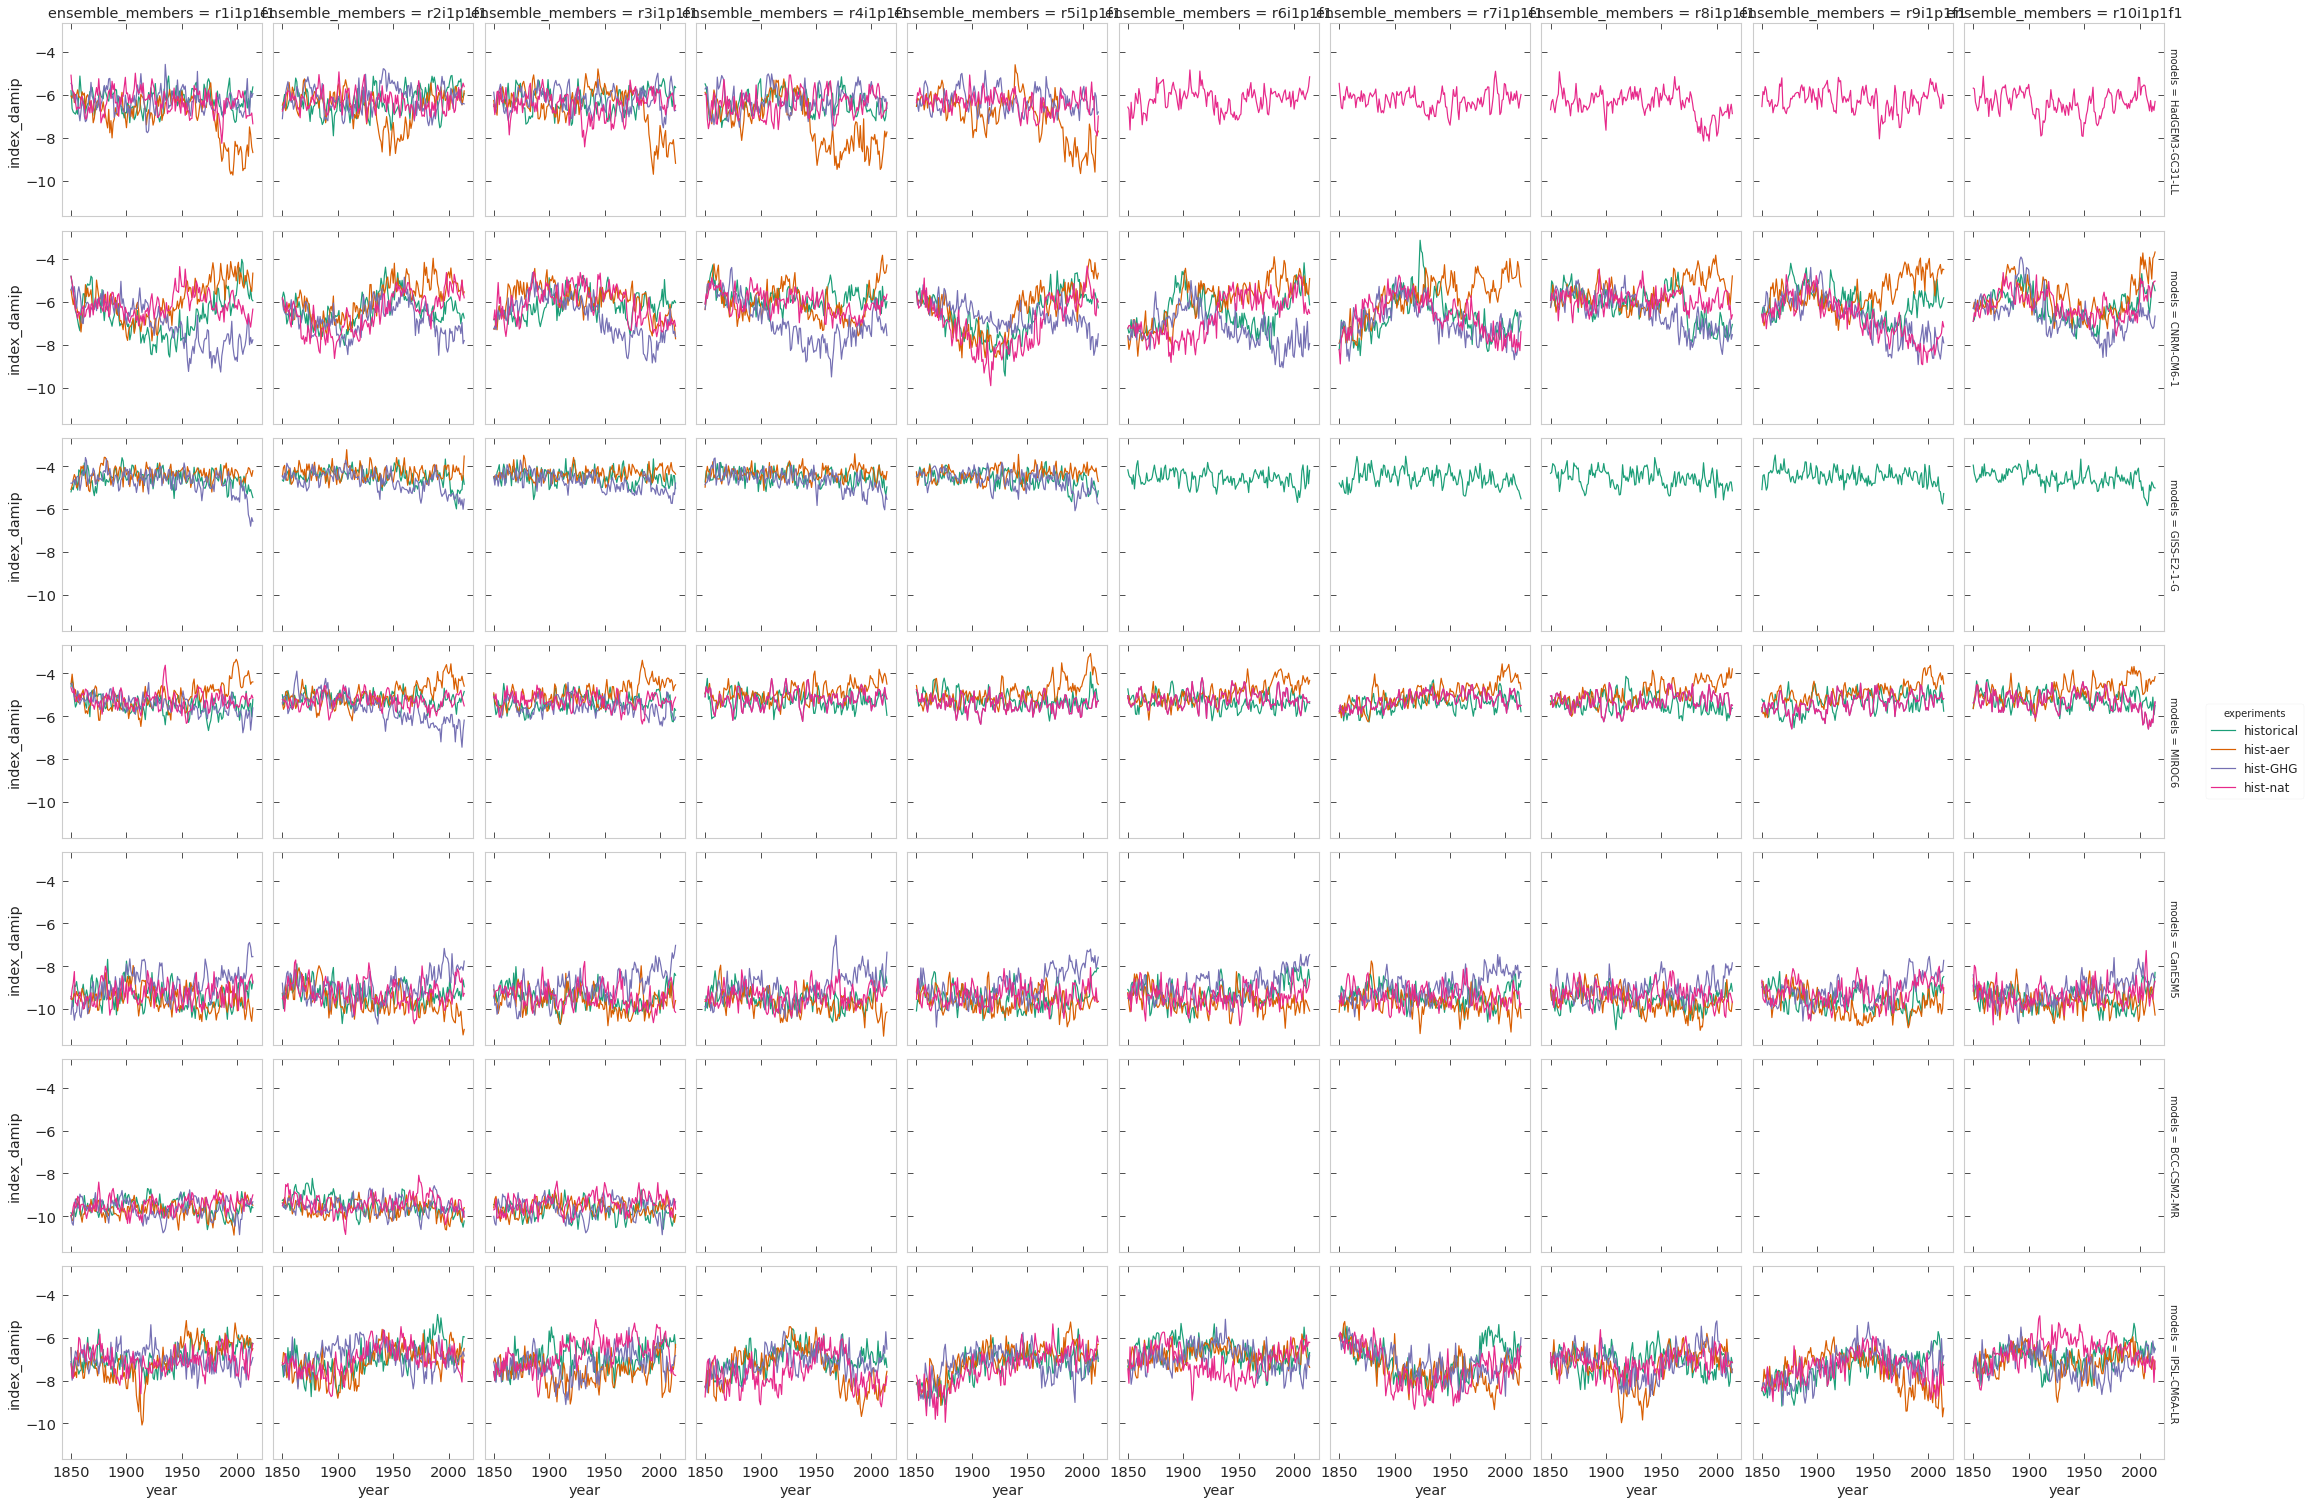

In [108]:
damip_amoc.index_damip.plot(x='year', row = 'models', col='ensemble_members', hue='experiments')